In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(patchwork)
library(stringr)
library('dplyr')
library('tidyr')
library('ggplot2')
library('Matrix')
library(tibble)

set.seed(17)

Attaching SeuratObject

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: ensembldb

Loading required package: GenomicRanges

Loading required package: GenomicFeatures

Loading required p

In [85]:
library(patchwork)

# Find RNA DEG

In [2]:
obj.RNA <- readRDS("/net/bmc-lab5/data/kellis/users/ruiwenfu/scRNA/metastatic_all/takeda_39metastaticSamples_mt10_SCT_RPCAintegrated_cDC021022.rds")

In [24]:
Idents(obj.RNA) <- "Ident"
DefaultAssay(obj.RNA) <- "SCT" 

cDC3markers <- FindMarkers(obj.RNA, ident.1 = 'cDC3', min.pct = 0.25)

In [25]:
DEGlist <- cDC3markers %>% filter(p_val_adj <0.001)#%>% filter(avg_log2FC > 0 ) %>% arrange(p_val_adj)

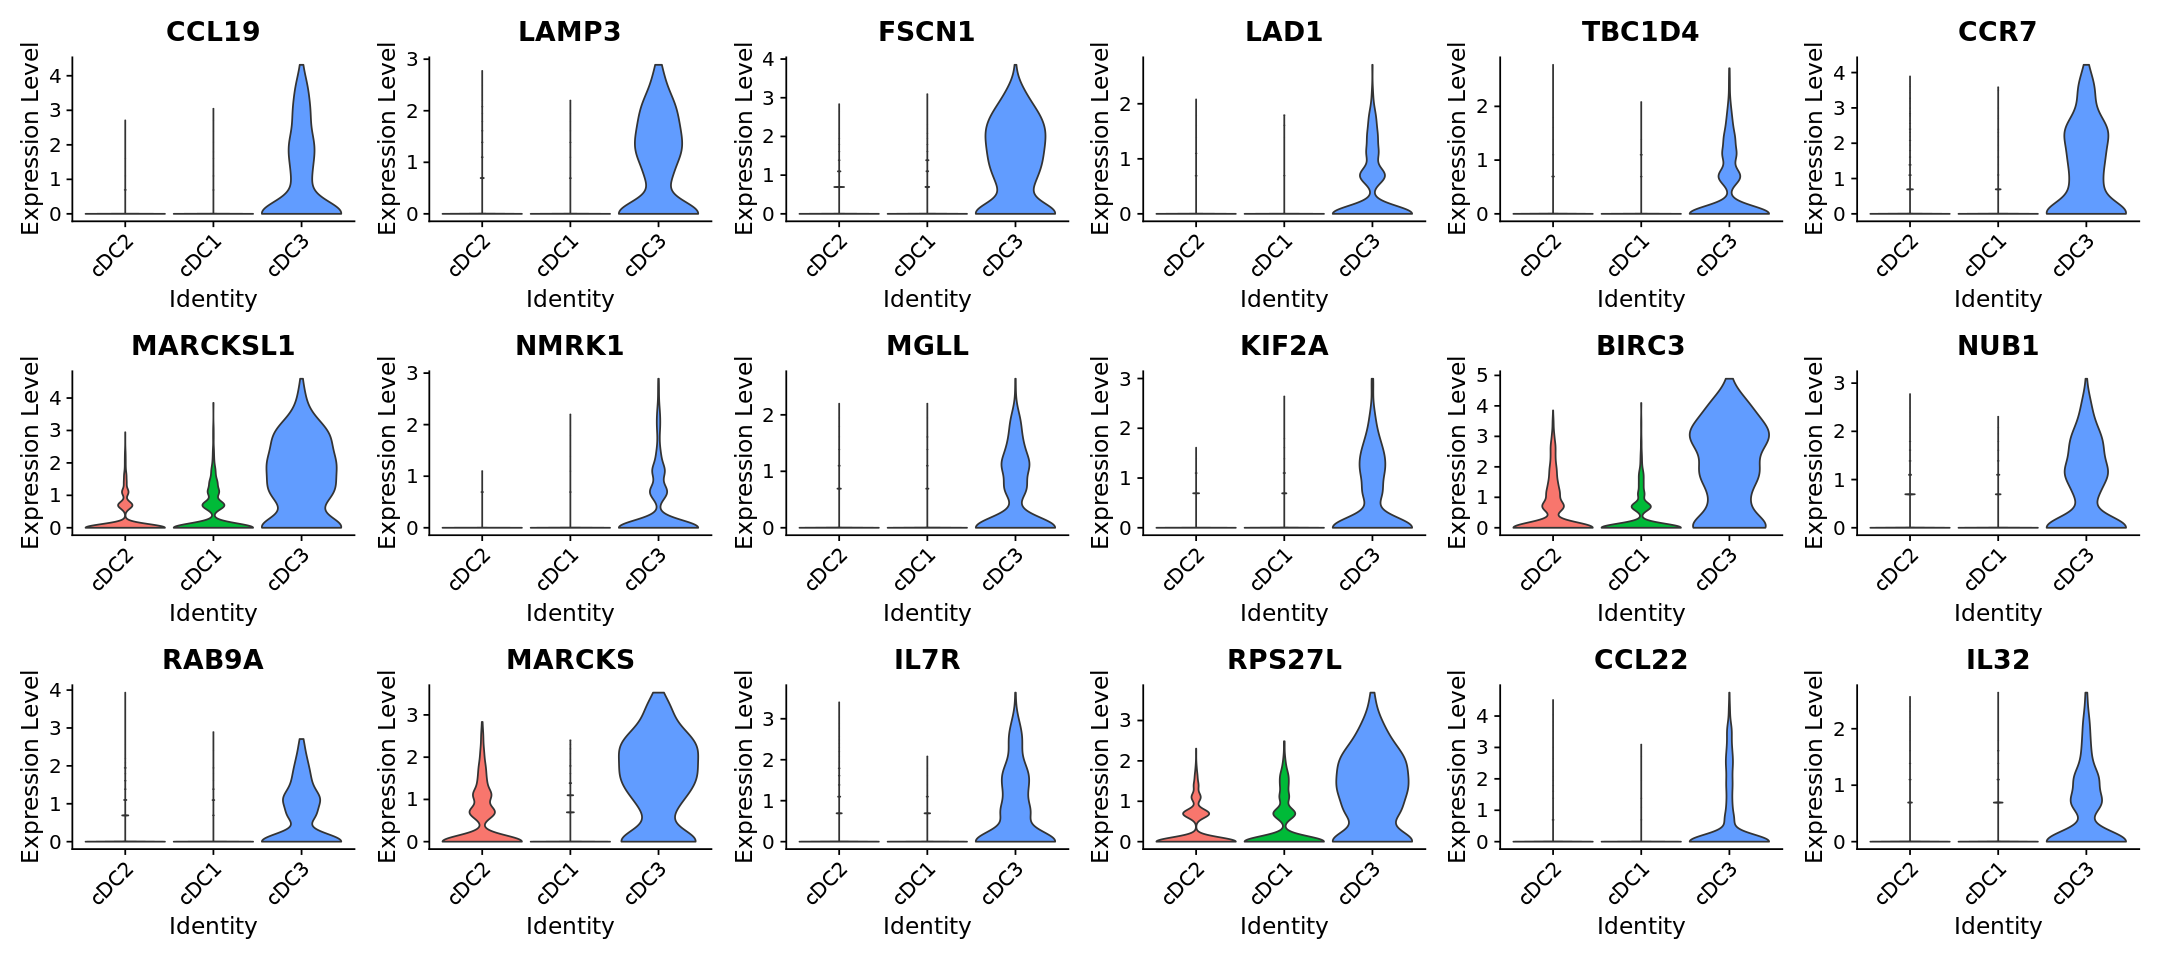

In [19]:
options(repr.plot.height = 8, repr.plot.width = 18)

VlnPlot(obj.RNA, features = rownames(DEGlist)[1:18], ncol = 6, pt.size = 0)

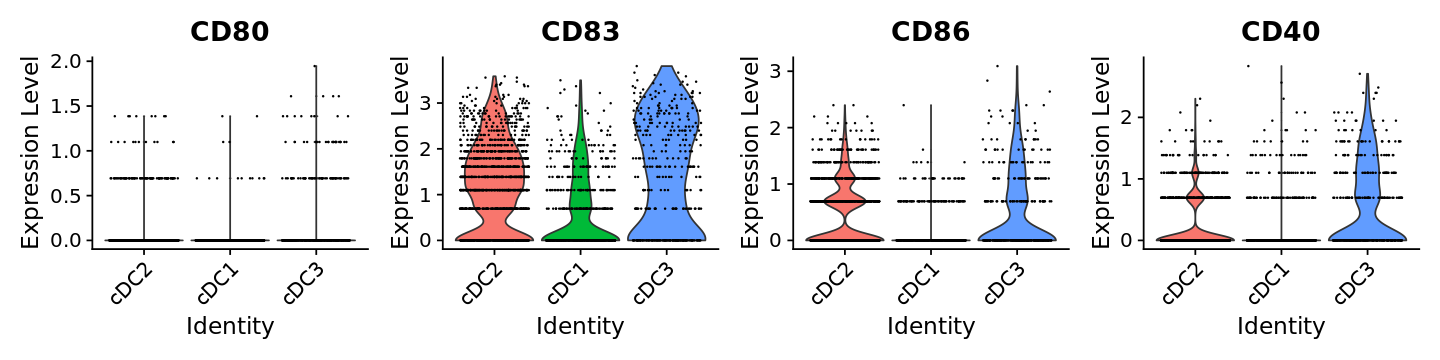

In [102]:
options(repr.plot.height = 3, repr.plot.width = 12)

VlnPlot(obj.RNA, features = c('CD80','CD83','CD86', 'CD40'),  ncol = 4)

# dimensionality reduction on ATAC

In [3]:
obj.ATAC <- readRDS( "/net/bmc-lab5/data/kellis/users/ruiwenfu/scATAC/metastatic_all/takedaICI_ATAC_15samples_cDC031821.rds")

In [8]:
obj.ATAC

An object of class Seurat 
876943 features across 235 samples within 3 assays 
Active assay: gene.activities (19607 features, 18145 variable features)
 2 other assays present: peaks, peaks_ChromatinAssay
 7 dimensional reductions calculated: lsi, harmony, umap, featureumap, globalumap, pca, DEGumap

## PCA

In [113]:
DefaultAssay(obj.ATAC) <- "gene.activities" 

obj.ATAC <- NormalizeData(
  object = obj.ATAC,
  assay = 'gene.activities',
  normalization.method = 'LogNormalize',
  scale.factor = median(obj.ATAC$nCount_gene.activities)
)

obj.ATAC <- ScaleData(obj.ATAC, features = rownames(obj.ATAC))

Centering and scaling data matrix



In [42]:
obj.ATAC <- RunPCA(obj.ATAC, assay = 'gene.activities', features = rownames(DEGlist), verbose= FALSE)

In [43]:
library(harmony)
obj.ATAC <- RunHarmony(
  object = obj.ATAC,
  group.by.vars = 'orig.ident',
  reduction = 'pca',
  assay.use = 'gene.activities',
  project.dim = FALSE, verbose = FALSE
)


## SVD

In [95]:
DefaultAssay(obj.ATAC) <- "peaks" 
obj.ATAC <- RunTFIDF(obj.ATAC)
obj.ATAC <- FindTopFeatures(obj.ATAC, min.cutoff = 20)

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"


In [96]:
obj.ATAC <- RunSVD(obj.ATAC)

Running SVD

Scaling cell embeddings



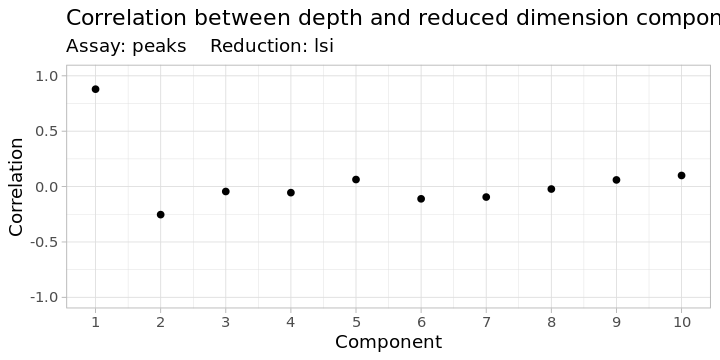

In [97]:
options(repr.plot.height = 3, repr.plot.width = 6)
#The first LSI component often captures sequencing depth (technical variation) rather than biological variation.
#If this is the case, the component should be removed from downstream analysis.
DepthCor(obj.ATAC)

In [98]:
library(harmony)
obj.ATAC <- RunHarmony(
  object = obj.ATAC,
  group.by.vars = 'orig.ident',
  reduction = 'lsi',
  assay.use = 'peaks',
  project.dim = FALSE, verbose = FALSE
)

## UMAP

In [44]:
obj.ATAC[["DEGumap"]] <- NULL
obj.ATAC <- RunUMAP(obj.ATAC, dims = 2:30, reduction = 'harmony', verbose = FALSE, reduction.name = "DEGumap")

Warning message:
"Cannot add objects with duplicate keys (offending key: UMAP_), setting key to 'degumap_'"


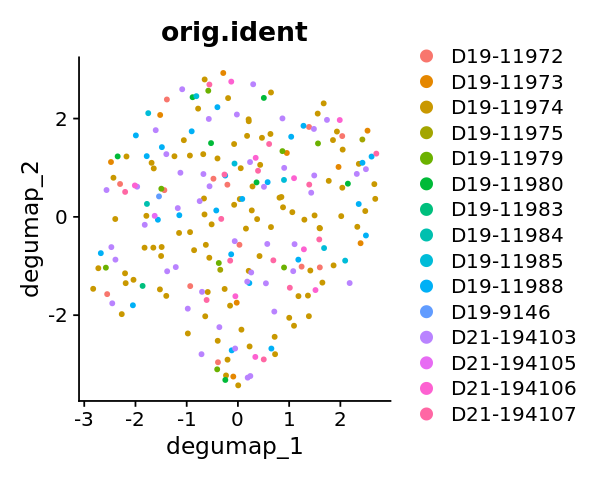

In [45]:
options(repr.plot.height = 4, repr.plot.width = 5)

DimPlot(obj.ATAC, reduction = "DEGumap", group.by = c( 'orig.ident'), 
    label.size = 3, repel = TRUE)

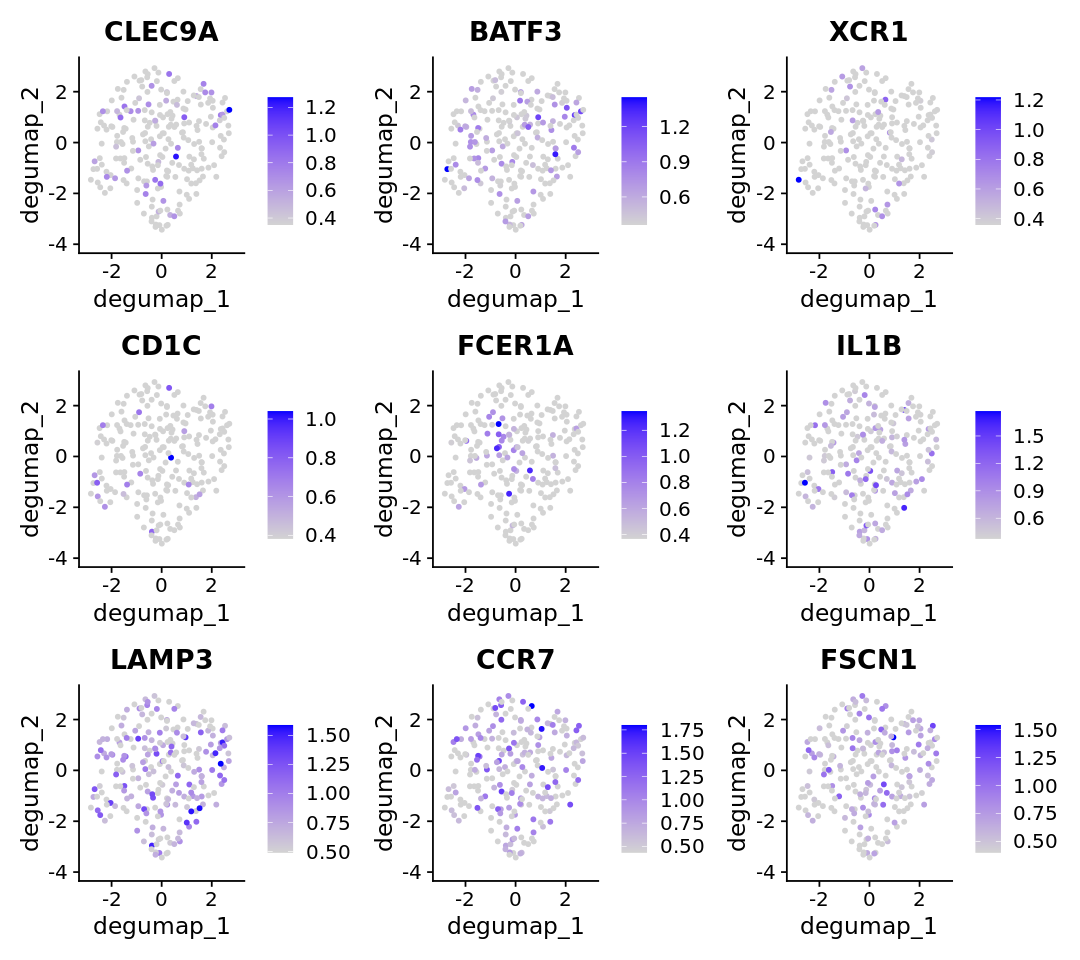

In [46]:
DefaultAssay(obj.ATAC) <- 'gene.activities'

options(repr.plot.height = 8, repr.plot.width = 9)
FeaturePlot(obj.ATAC, features = c('CLEC9A','BATF3','XCR1', 'CD1C','FCER1A','IL1B',
                                  'LAMP3','CCR7', 'FSCN1'), ncol = 3,reduction = "DEGumap",  min.cutoff = "q9",)

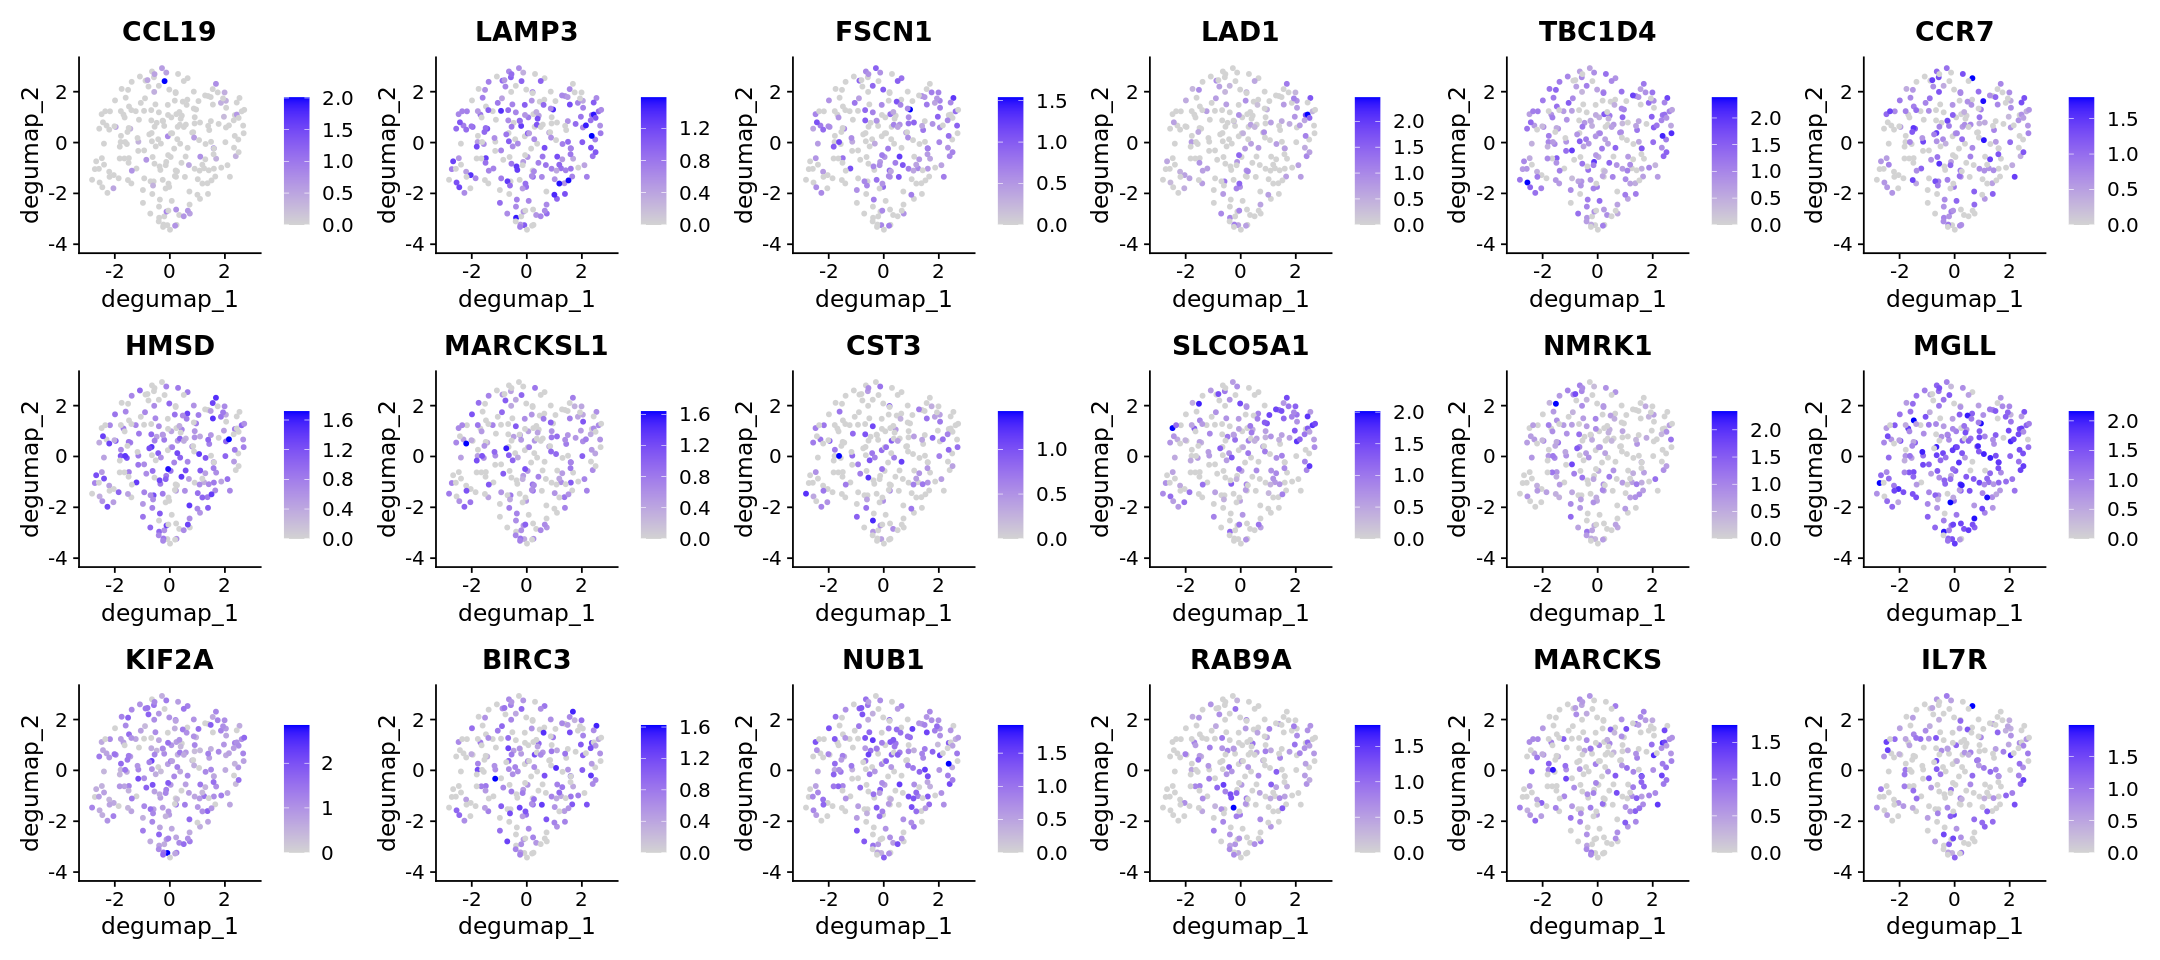

In [47]:
options(repr.plot.height = 8, repr.plot.width = 18)
FeaturePlot(obj.ATAC, features = rownames(DEGlist)[1:18], ncol = 6,reduction = "DEGumap")

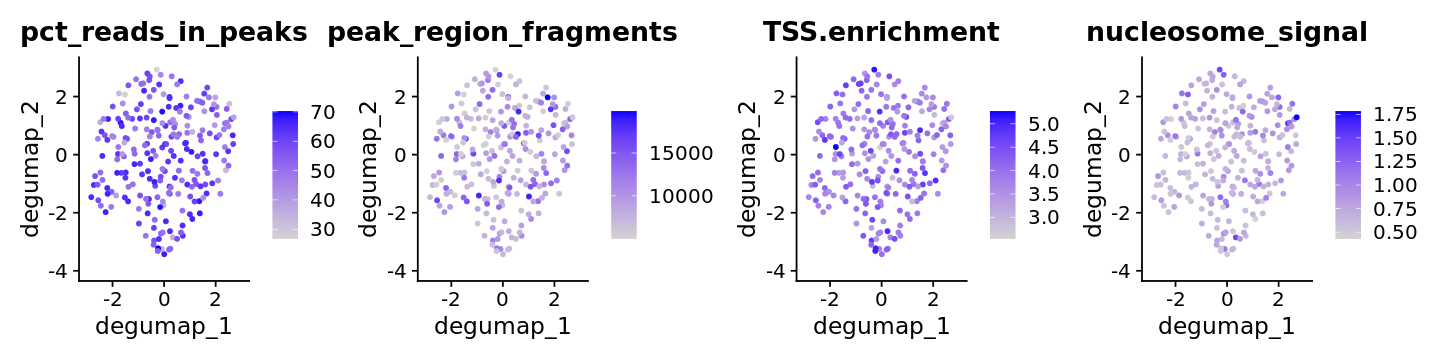

In [48]:
options(repr.plot.height = 3, repr.plot.width = 12)

FeaturePlot(
  object = obj.ATAC,
  features = c('pct_reads_in_peaks', 'peak_region_fragments',
               'TSS.enrichment',  'nucleosome_signal'),
    reduction = "DEGumap",
  ncol = 4
)

# Label transfer

In [4]:
DefaultAssay(obj.RNA) <- "RNA" 

In [6]:
RNA

An object of class Seurat 
57840 features across 2160 samples within 3 assays 
Active assay: RNA (28295 features, 0 variable features)
 2 other assays present: SCT, integrated
 2 dimensional reductions calculated: pca, umap

In [8]:
ATAC

An object of class Seurat 
876943 features across 235 samples within 3 assays 
Active assay: gene.activities (19607 features, 18145 variable features)
 2 other assays present: peaks, peaks_ChromatinAssay
 7 dimensional reductions calculated: lsi, harmony, umap, featureumap, globalumap, pca, DEGumap

In [24]:
# Identify anchors
transfer.anchors <- FindTransferAnchors(reference = obj.RNA, query = obj.ATAC,
                                        features = VariableFeatures(object = obj.ATAC),
    reference.assay = "RNA", query.assay = "gene.activities", reduction = "cca")

Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
"Running CCA on different assays"
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1173 anchors

Filtering anchors

	Retained 1027 anchors



In [83]:
predicted.celltype <- TransferData(
  anchorset = transfer.anchors,
  refdata = obj.RNA$Ident,
  weight.reduction = obj.ATAC[['lsi']],
  dims = 2:40
)

# obj.ATAC <- AddMetaData(object = obj.ATAC, metadata = predicted.celltype)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



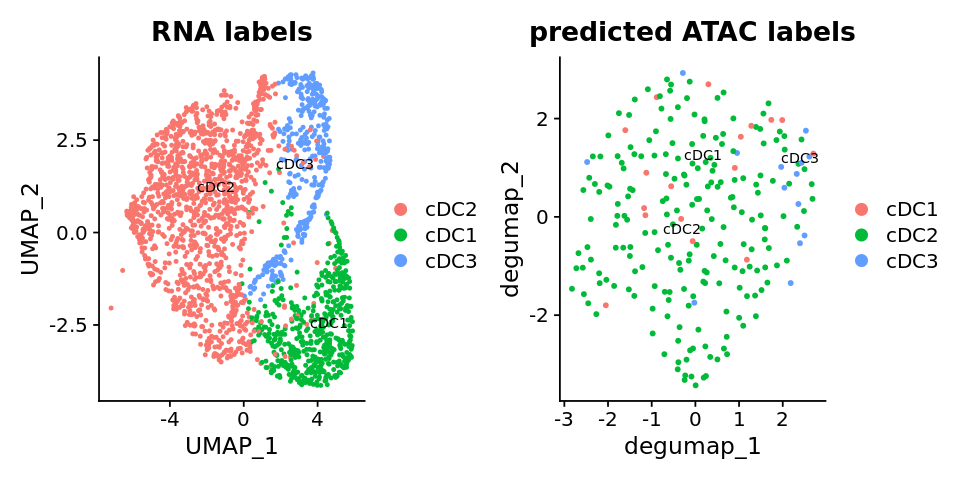

In [53]:
options(repr.plot.height = 4, repr.plot.width = 8)
p1 <- DimPlot(RNA, reduction = "umap", group.by = c("Ident"), label = TRUE, 
              label.size = 3, repel = TRUE)+ ggtitle("RNA labels")
p2 <- DimPlot(obj.ATAC, reduction = "DEGumap", group.by = c("predicted.id"), label = TRUE, 
              label.size = 3, repel = TRUE)+ ggtitle("predicted ATAC labels")
p1+p2

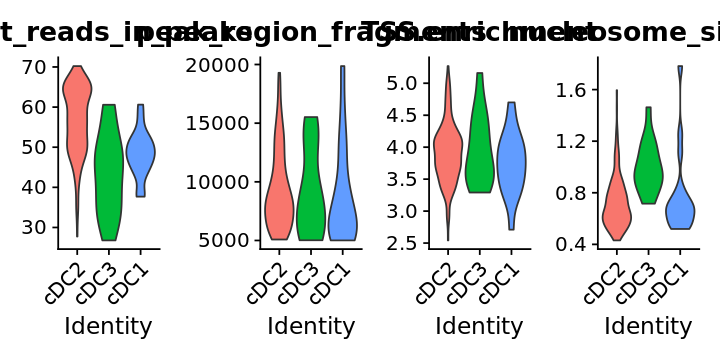

In [96]:
options(repr.plot.height = 3, repr.plot.width = 6)

VlnPlot(
  object = obj.ATAC,
  features = c('pct_reads_in_peaks', 'peak_region_fragments',
               'TSS.enrichment',  'nucleosome_signal'),
#     group.by ='orig.ident',
  pt.size = 0,
  ncol = 4
)

In [75]:
saveRDS(obj.ATAC, "/net/bmc-lab5/data/kellis/users/ruiwenfu/scATAC/metastatic_all/takedaICI_ATAC_15samples_cDC031821.rds")

In [3]:
obj.ATAC <- readRDS("/net/bmc-lab5/data/kellis/users/ruiwenfu/scATAC/metastatic_all/takedaICI_ATAC_15samples_cDC031821.rds")

# Coembed

In [4]:
DefaultAssay(obj.RNA) <- "RNA" 
DefaultAssay(obj.ATAC) <- "gene.activities" 

In [5]:
# Identify anchors
transfer.anchors <- FindTransferAnchors(reference = obj.RNA, query = obj.ATAC,
                                        features = VariableFeatures(object = obj.ATAC),
    reference.assay = "RNA", query.assay = "gene.activities", reduction = "cca")

Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
"Running CCA on different assays"
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1173 anchors

Filtering anchors

	Retained 1027 anchors



In [9]:
genes.use <- VariableFeatures(obj.ATAC)
genes.use <- rownames(obj.RNA)[rownames(obj.RNA) %in% genes.use]
refdata <- GetAssayData(obj.RNA, assay = "RNA", slot = "data")[genes.use,]

In [10]:
imputation <- TransferData(anchorset = transfer.anchors, refdata = refdata, weight.reduction = obj.ATAC[["lsi"]],
    dims = 2:30)
obj.ATAC[["RNA"]] <- imputation

Finding integration vectors

Finding integration vector weights

Transfering 16913 features onto reference data



In [11]:
DefaultAssay(obj.ATAC) <- "RNA" 
DefaultAssay(obj.RNA) <- "RNA" 

In [15]:
obj.ATAC@meta.data <- obj.ATAC@meta.data %>% mutate(technology = 'ATAC', Ident = predicted.id)
obj.RNA@meta.data <- obj.RNA@meta.data %>% mutate(technology = 'RNA', orig.ident = sample_ID_long)

coembed <- merge(x = obj.RNA, y = obj.ATAC)

Warning message:
"Attempting to merge an SCTAssay with another Assay type 
Converting all to standard Assay objects."
Warning message:
"Attempting to merge an SCTAssay with another Assay type 
Converting all to standard Assay objects."


In [19]:
coembed <- ScaleData(coembed, features = genes.use, do.scale = FALSE)
coembed <- RunPCA(coembed, features = genes.use, verbose = FALSE)
library(harmony)
coembed <- RunHarmony(
  object = coembed,
  group.by.vars = c('technology','orig.ident'),
  reduction = 'pca',
  assay.use = 'RNA',
  dims.use = 1:40,
  project.dim = FALSE
)
coembed <- RunUMAP(coembed, dims = 1:40, reduction = 'harmony', verbose = FALSE)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations



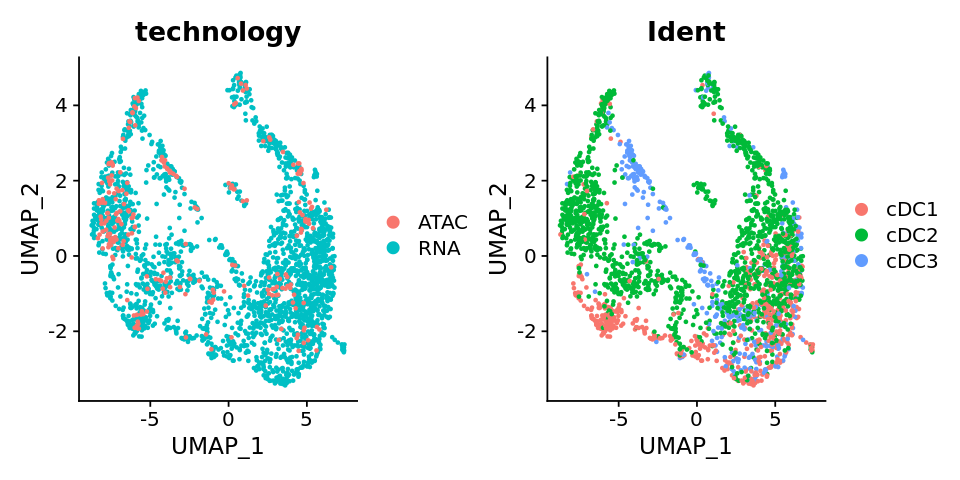

In [20]:
options(repr.plot.height = 4, repr.plot.width = 8)
DimPlot(coembed, group.by = c("technology","Ident"), reduction = "umap")

In [21]:
saveRDS(coembed, "/net/bmc-lab5/data/kellis/users/ruiwenfu/scATAC/metastatic_all/takedaICI_ATAC_15samples_cDC_coembed_RNA042022.rds")

# Clustering

In [69]:
obj.ATAC <- FindNeighbors(object = obj.ATAC, reduction = 'harmony', dims = 2:30)
obj.ATAC <- FindClusters(object = obj.ATAC, verbose = FALSE, resolution = c( 0.9))

Computing nearest neighbor graph

Computing SNN



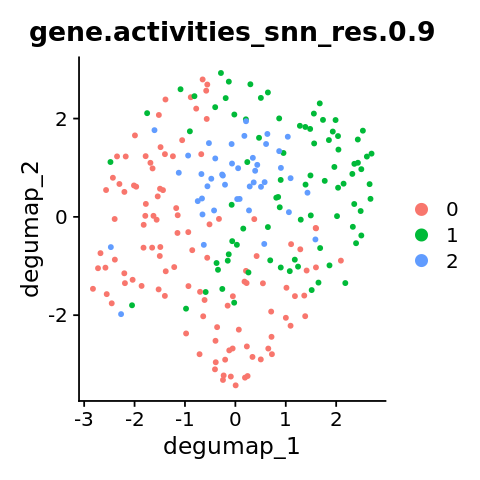

In [70]:
options(repr.plot.height = 4, repr.plot.width = 4)

DimPlot(obj.ATAC, reduction = "DEGumap", group.by = c( 'gene.activities_snn_res.0.9'), 
    label.size = 3, repel = TRUE)

## vioins

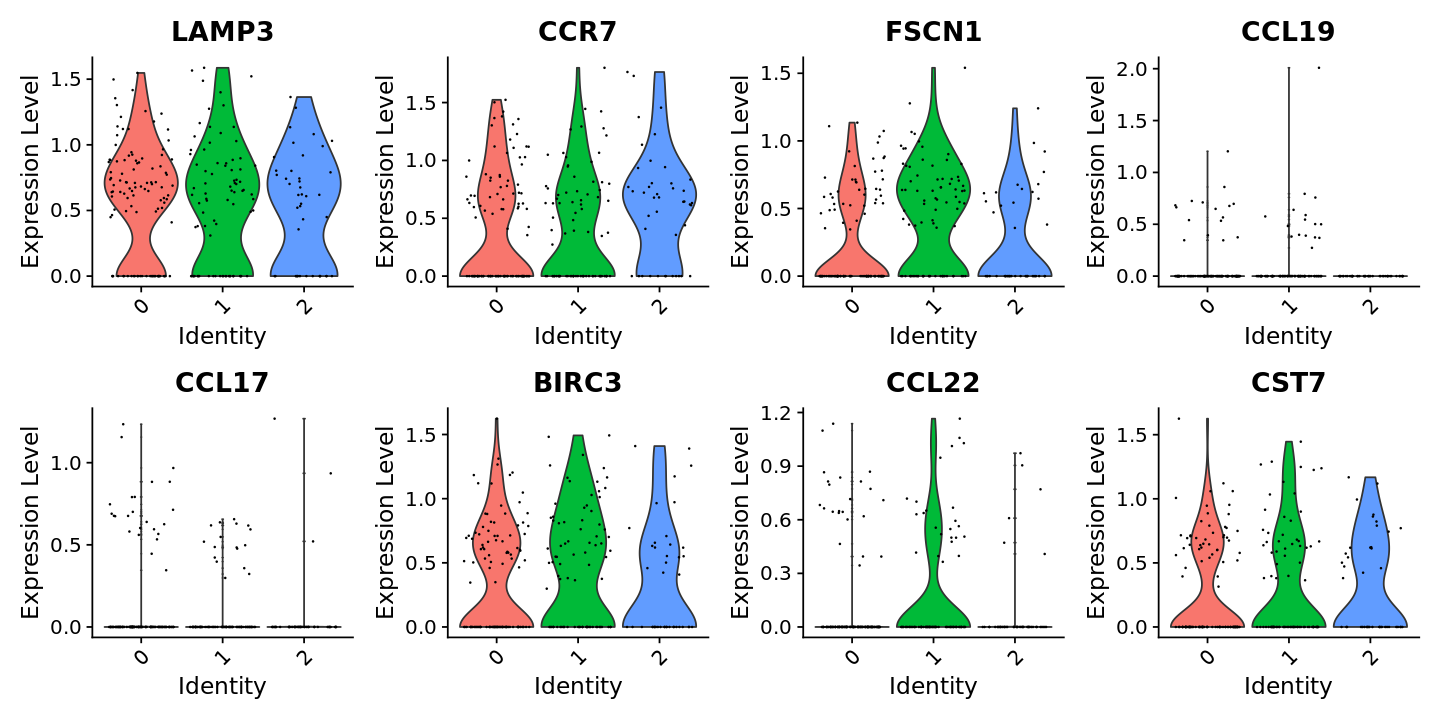

In [73]:

options(repr.plot.height = 6, repr.plot.width = 12)
VlnPlot(obj.ATAC, features = c('LAMP3','CCR7', 'FSCN1', 'CCL19','CCL17', 'BIRC3', 
                           'CCL22', 'CST7'), group.by = c("gene.activities_snn_res.0.9"),
        ncol = 4)

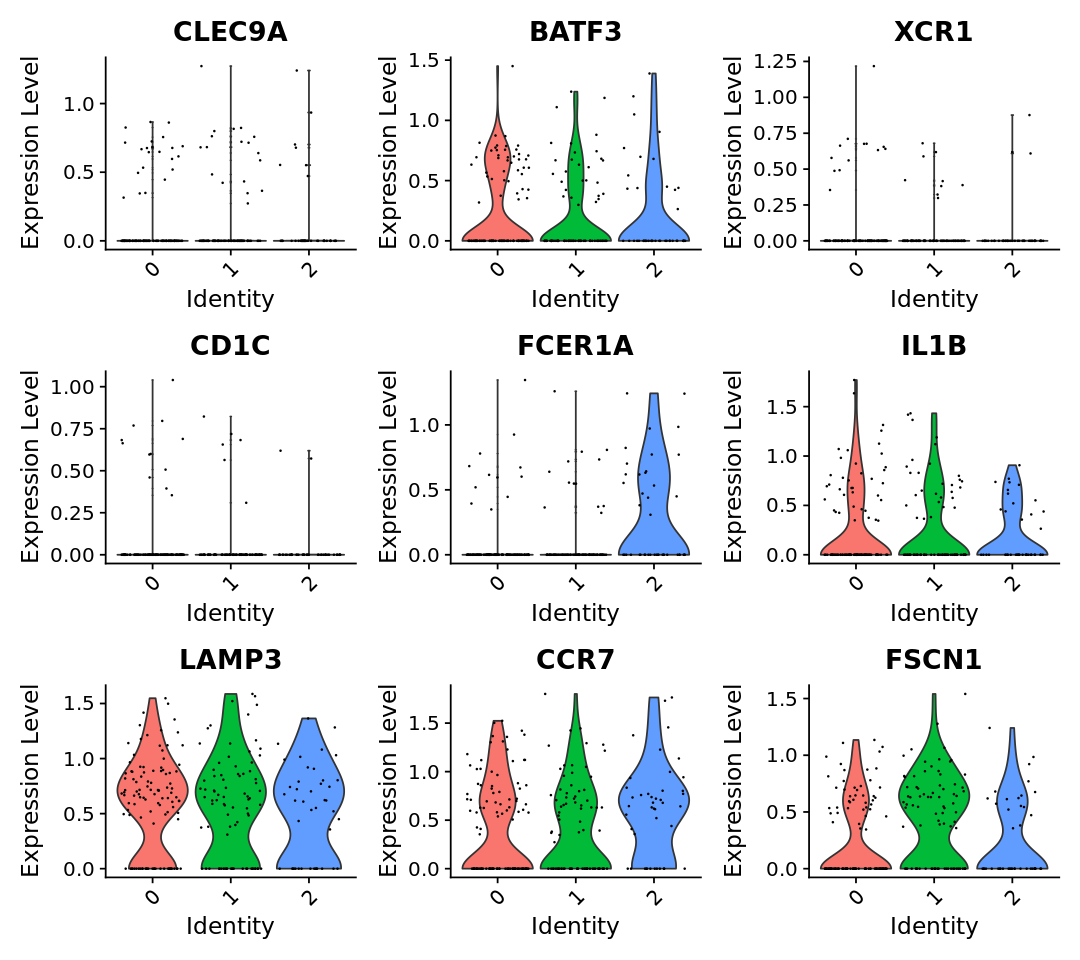

In [74]:
# DefaultAssay(obj.ATAC) <- 'gene.activities'

options(repr.plot.height = 8, repr.plot.width = 9)
VlnPlot(obj.ATAC, features = c('CLEC9A','BATF3','XCR1', 'CD1C','FCER1A','IL1B',
                                  'LAMP3','CCR7', 'FSCN1'), group.by = c("gene.activities_snn_res.0.9"),
        ncol = 3)

In [80]:
Idents(obj.ATAC) <- 'predicted.id'

In [66]:
table(obj.ATAC[[]]$predicted.id)


cDC1 cDC2 cDC3 
  17  204   14 

In [64]:
table(obj.RNA[[]]$Ident)


cDC2 cDC1 cDC3 
1286  527  347 

# Find differentially accessible peaks

In [82]:
obj.ATAC

An object of class Seurat 
893856 features across 235 samples within 4 assays 
Active assay: peaks_ChromatinAssay (428668 features, 129923 variable features)
 3 other assays present: peaks, gene.activities, RNA
 7 dimensional reductions calculated: lsi, harmony, umap, featureumap, globalumap, pca, DEGumap

In [26]:
# change back to working with peaks instead of gene activities
DefaultAssay(obj.ATAC) <- 'peaks_ChromatinAssay'

da_peaks <- FindMarkers(
  object = obj.ATAC,
  ident.1 = "cDC3",
  min.pct = 0.05,
  test.use = 'LR',
  latent.vars = 'peak_region_fragments'
)



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

In [47]:
write.csv(da_peaks, "/net/bmc-lab5/data/kellis/users/ruiwenfu/scATAC/metastatic_all/cDC3_da_peaks.csv",
          row.names=TRUE)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr12:121513585-121514850,2.744894e-08,1.387501,0.500,0.018,0.01176648
chr1:206609252-206610198,3.763268e-08,1.415832,0.357,0.000,0.01613193
chr1:153731978-153732847,4.088556e-08,1.513522,0.357,0.000,0.01752633
chr6:286393-288198,6.262248e-08,1.386953,0.643,0.059,0.02684425
chr16:17027693-17028442,1.335680e-07,1.518534,0.500,0.018,0.05725631
chr4:153521787-153523840,1.529551e-07,1.244412,0.643,0.086,0.06556698


In [125]:
top_peaks <- ClosestFeature(obj.ATAC, regions = rownames(da_peaks)[1:100], sep = c(":", "-"))

In [127]:
DEG_intersect <- intersect(rownames(DEGlist), unique(top_peaks$gene_name))

Warning message:
"Removed 13 rows containing missing values (position_stack)."
Warning message:
"Removed 114 rows containing missing values (geom_segment)."
Warning message:
"Removed 7 rows containing missing values (position_stack)."
Warning message:
"Removed 61 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 46 rows containing missing values (geom_segment)."


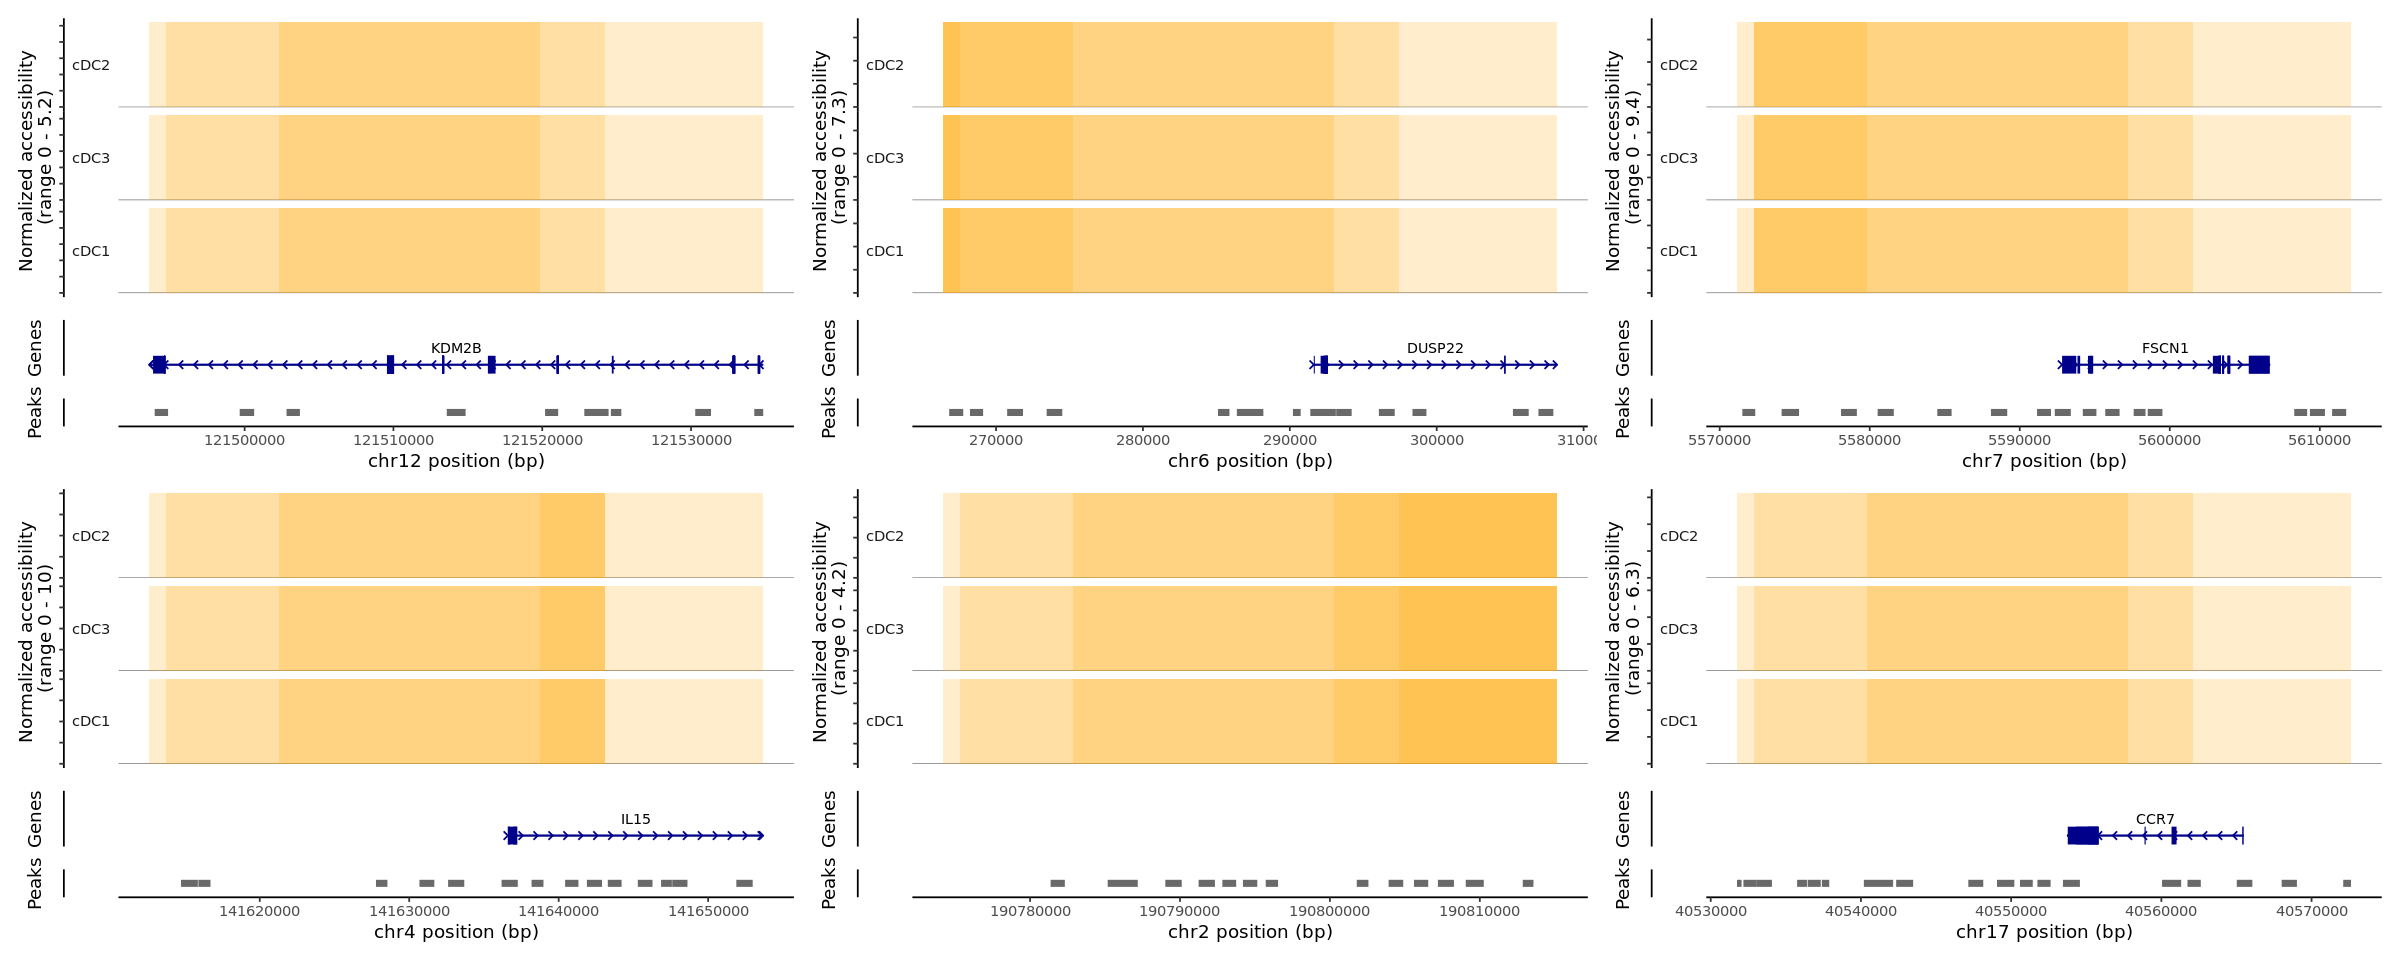

In [139]:
options(repr.plot.height = 8, repr.plot.width = 20)
ranges.show <- StringToGRanges(top100DE_peaks[top100DE_peaks$gene_name %in% DEG_intersect,]$query_region[1:6],
                               sep = c(":", "-"))
ranges.show$color <- "orange"

CoveragePlot(
  object = obj.ATAC,
  region = top100DE_peaks[top100DE_peaks$gene_name %in% DEG_intersect,]$query_region[1:6],
  sep = c(":", "-"), assay= 'peaks_ChromatinAssay',
  extend.upstream = 20000,
  extend.downstream = 20000,
    ncol =3, 
    region.highlight = ranges.show)

## get gene annotations
https://satijalab.org/signac/0.2/articles/merging.html#merge-fragment-files-1

In [34]:
obj.ATAC$peaks_ChromatinAssay

ChromatinAssay data with 428668 features for 235 cells
Variable features: 129923 
Genome: hg38 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

In [35]:
Annotation(obj.ATAC[["peaks_ChromatinAssay"]])

GRanges object with 3021151 ranges and 5 metadata columns:
                  seqnames        ranges strand |           tx_id   gene_name
                     <Rle>     <IRanges>  <Rle> |     <character> <character>
  ENSE00001489430     chrX 276322-276394      + | ENST00000399012      PLCXD1
  ENSE00001536003     chrX 276324-276394      + | ENST00000484611      PLCXD1
  ENSE00002160563     chrX 276353-276394      + | ENST00000430923      PLCXD1
  ENSE00001750899     chrX 281055-281121      + | ENST00000445062      PLCXD1
  ENSE00001489388     chrX 281192-281684      + | ENST00000381657      PLCXD1
              ...      ...           ...    ... .             ...         ...
  ENST00000361739     chrM     7586-8269      + | ENST00000361739      MT-CO2
  ENST00000361789     chrM   14747-15887      + | ENST00000361789      MT-CYB
  ENST00000361851     chrM     8366-8572      + | ENST00000361851     MT-ATP8
  ENST00000361899     chrM     8527-9207      + | ENST00000361899     MT-ATP6
  ENS

In [3]:

#### extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
### change to UCSC style
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"


Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

# add in fragment file

In [3]:
obj.ATAC

An object of class Seurat 
876943 features across 235 samples within 3 assays 
Active assay: gene.activities (19607 features, 18145 variable features)
 2 other assays present: peaks, peaks_ChromatinAssay
 7 dimensional reductions calculated: lsi, harmony, umap, featureumap, globalumap, pca, DEGumap

In [8]:
FilterCells(
  fragments = '/net/bmc-lab5/data/kellis/users/ruiwenfu/scATAC/metastatic_all/fragments/noHeader_fragments.tsv.gz',
  cells = colnames(obj.ATAC),
  outfile = '/net/bmc-lab5/data/kellis/users/ruiwenfu/scATAC/metastatic_all/fragments/cDC_fragmentsFiltered.tsv.gz'
)

Warning message in FilterCells(fragments = "/net/bmc-lab5/data/kellis/users/ruiwenfu/scATAC/metastatic_all/fragments/noHeader_fragments.tsv.gz", :
"Output file already exists, file will be overwritten"

Compressing filtered file

Indexing fragment file



In [9]:
fragments <- CreateFragmentObject(
  path = '/net/bmc-lab5/data/kellis/users/ruiwenfu/scATAC/metastatic_all/fragments/cDC_fragmentsFiltered.tsv.gz',
  cells = colnames(obj.ATAC), 
  validate.fragments = TRUE
)

Computing hash



In [13]:
chromatinAssay <- obj.ATAC[["peaks_ChromatinAssay"]] 
Fragments(chromatinAssay) <- fragments

In [15]:
obj.ATAC[["peaks_ChromatinAssay"]] <- chromatinAssay

In [23]:
Idents(obj.ATAC) <- obj.ATAC[[]]$predicted.id

In [30]:
saveRDS(obj.ATAC, "/net/bmc-lab5/data/kellis/users/ruiwenfu/scATAC/metastatic_all/takedaICI_ATAC_15samples_cDC031821.rds")

Warning message:
"Removed 28 rows containing missing values (geom_segment)."


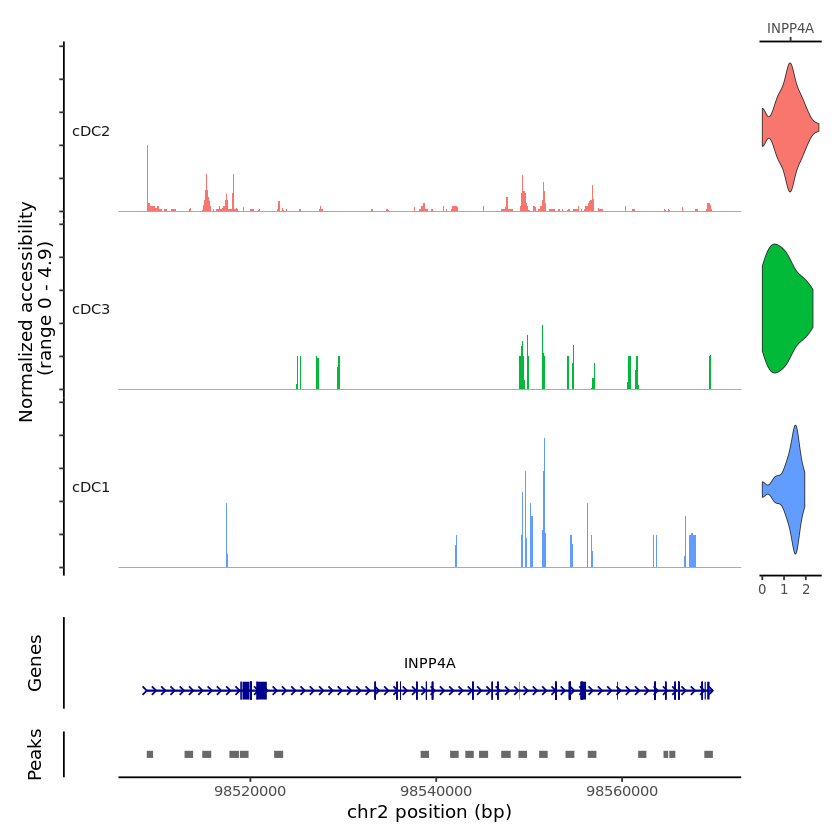

In [29]:
CoveragePlot(
  object = obj.ATAC,
  region = 'chr2:98548849-98549773', sep = c(":", "-"), assay= 'peaks_ChromatinAssay',
  extend.upstream = 40000,
  extend.downstream = 20000,
    expression.assay = 'gene.activities',
 features = 'INPP4A'
    )

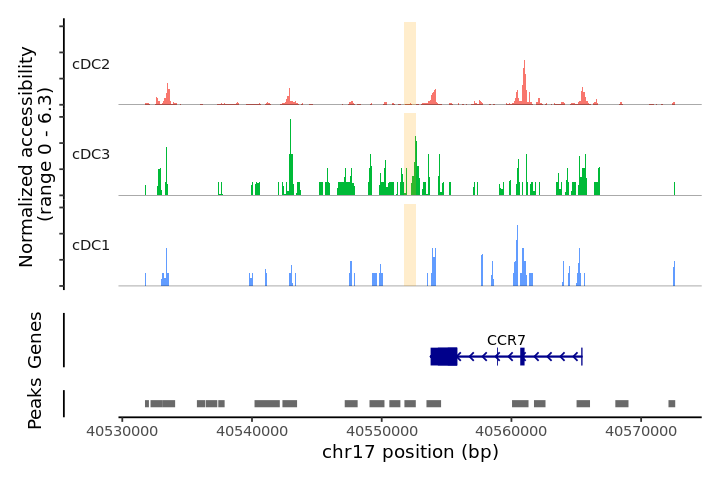

In [150]:
options(repr.plot.height = 4, repr.plot.width = 6)

i <- 6

ranges.show <- StringToGRanges(top100DE_peaks[top100DE_peaks$gene_name %in% DEG_intersect,]$query_region[i],
                               sep = c(":", "-"))
ranges.show$color <- "orange"

CoveragePlot(
  object = obj.ATAC,
  region = top100DE_peaks[top100DE_peaks$gene_name %in% DEG_intersect,]$query_region[i],
  sep = c(":", "-"), assay= 'peaks_ChromatinAssay',
  extend.upstream = 20000,
  extend.downstream = 20000,
    ncol =3, 
    region.highlight = ranges.show)